In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean as cmo
import seaborn as sb

fpath = "/work/Katherine.Turner/tempest-extremes/odiv-251"

def mask_composite(ds, var, start_year=0, min_lat=-90, max_lat=90, min_lon=0, max_lon=360):
    X = np.meshgrid(ds.x.data,ds.y.data)
    mask = xr.DataArray(np.sqrt(X[0]**2 + X[1]**2) <= 10, dims=['x', 'y'])
    
    idx_region = (ds.snap_time.dt.year > start_year) & (ds.snap_lat >= min_lat) & (ds.snap_lat <= max_lat) & \
    (ds.snap_lon >= min_lon) & (ds.snap_lon <= max_lon)
    
    test = ds[var][idx_region,:,:]
    test = xr.where(abs(test)>1e10, np.nan, test)
    test = xr.where(test==0, np.nan, test)

    out_masked = xr.where(mask, test, np.nan)
    return out_masked

In [2]:
ds_hfds = xr.open_dataset(f"{fpath}/comp_hfds/comp_hfds_anom.nc", use_cftime=True)
ds_massin = xr.open_mfdataset(f"{fpath}/comp_net_massin/comp_net_massin_anom.nc", use_cftime=True)
ds_massout = xr.open_mfdataset(f"{fpath}/comp_net_massout/comp_net_massout_anom.nc", use_cftime=True)

ds_dic = xr.open_dataset(f"{fpath}/comp_f_dic/comp_dic_stf_gas_anom.nc", use_cftime=True)
ds_o2 = xr.open_dataset(f"{fpath}/comp_f_o2/comp_o2_stf_gas_anom.nc", use_cftime=True)

In [3]:
#hfds_masked = mask_composite(ds_hfds, "snap_hfds_anom")
dic_masked = mask_composite(ds_dic, "snap_dic_stf_gas_anom")
#o2_masked = mask_composite(ds_o2, "snap_o2_stf_gas_anom")

In [21]:
time = ds_dic.snap_time
time_12 = time[time.dt.hour==12]
time_12

<xarray.DataArray 'snap_time' (snapshot: 216942)>
array([cftime.DatetimeNoLeap(151, 1, 1, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(151, 1, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(151, 1, 3, 12, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(245, 12, 29, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(245, 12, 30, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(245, 12, 31, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Dimensions without coordinates: snapshot

In [22]:
dic_masked = dic_masked[:,:,time.dt.hour==12]

Text(0.5, 0, 'Outgassing (mmol m$^{-2}$ day$^{-1}$)')

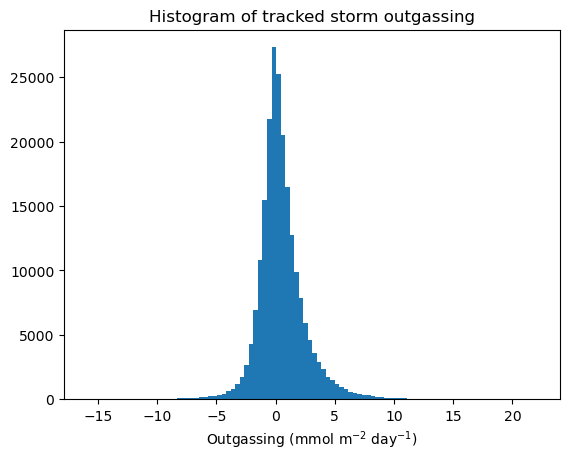

In [42]:
_,_,_ = (-1e3*24*60**2*dic_masked).mean(dim={'x','y'}).plot.hist(bins=100)
plt.title('Histogram of tracked storm outgassing')
plt.xlabel('Outgassing (mmol m$^{-2}$ day$^{-1}$)')

In [46]:
outgassing = (-1e3 * 24 * 60**2 * dic_masked).load()
outgassing_tot = outgassing.sum().load()

In [34]:
q = np.arange(0,100,2)
outgassing_q = np.zeros(len(q))

for i in range(len(q)):
    q0 = outgassing.mean(dim={'x','y'}).quantile(q[i]/100)
    q1 = outgassing.mean(dim={'x','y'}).quantile((q[i]+2)/100)
    idx_q = (outgassing.mean(dim={'x','y'}) >= q0) & (outgassing.mean(dim={'x','y'}) <= q1)
    
    outgassing_q[i] = outgassing[:,:,idx_q].sum() / outgassing_tot
    if i%5==0:
        print(2*i)

Text(0.5, 0, 'Percentile of storms by area-average CO$_2$ flux')

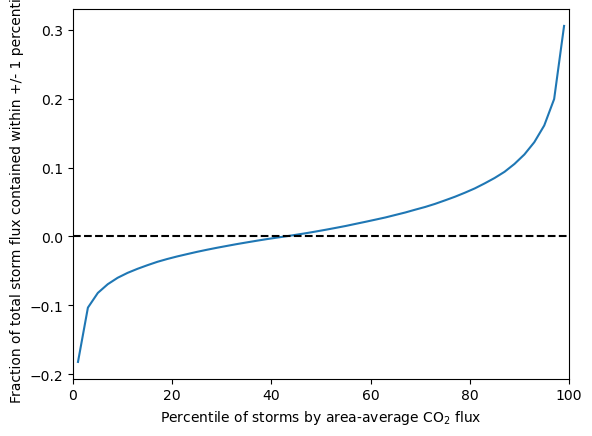

In [43]:
plt.plot(np.arange(1,100,2),outgassing_q)
plt.plot([0, 100], [0, 0], 'k--')
plt.xlim([0, 100])
plt.ylabel('Fraction of total storm flux contained within +/- 1 percentile')
plt.xlabel('Percentile of storms by area-average CO$_2$ flux')

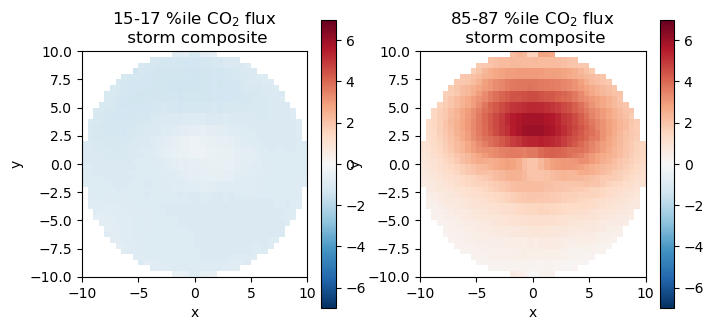

In [59]:
n = [15, 85]

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8,3.75))
for ii, i in enumerate(n):
    q0 = outgassing.mean(dim={'x','y'}).quantile(i/100)
    q1 = outgassing.mean(dim={'x','y'}).quantile((i+2)/100)
    idx_q = (outgassing.mean(dim={'x','y'}) >= q0) & (outgassing.mean(dim={'x','y'}) <= q1)
    
    outgassing[:,:,idx_q].mean(dim="snapshot").plot(ax=axs[ii], y='y', 
                                                    vmin=-7, vmax=7, 
                                                    cmap="RdBu_r")
    axs[ii].set_title(f"{i}-{i+2} %ile CO$_2$ flux \n storm composite")
    axs[ii].set_aspect(1)

In [68]:
q = dic_masked.mean(dim={'x','y'}).quantile(.999)
print(q)

idx_q = dic_masked.mean(dim={'x','y'}) >= q

q2 = dic_masked.mean(dim={'x','y'}).quantile(.001)
print(q2)

idx_q2 = dic_masked.mean(dim={'x','y'}) <= q2

<xarray.DataArray ()>
array(9.00825165e-08)
Coordinates:
    quantile  float64 0.999
<xarray.DataArray ()>
array(-1.32709537e-07)
Coordinates:
    quantile  float64 0.001


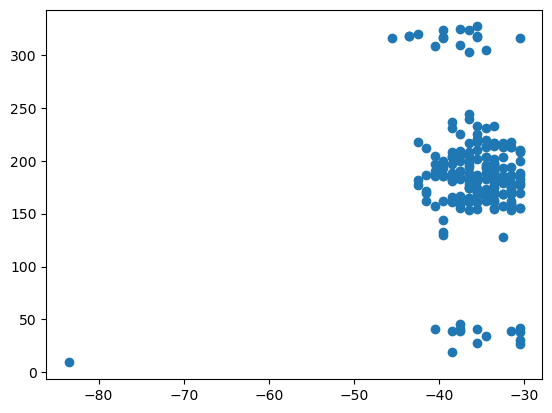

In [69]:
lat = ds_dic.snap_lat[ds_dic.snap_time.dt.hour==12]
lon = ds_dic.snap_lon[ds_dic.snap_time.dt.hour==12]

plt.scatter(lat[idx_q].data, lon[idx_q].data)

In [70]:
time_q = time_12[idx_q]
time_q2 = time_12[idx_q2]

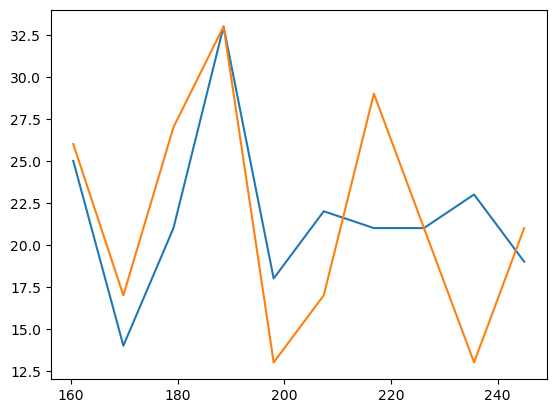

In [72]:
n,y, _ = time_q.dt.year.plot.hist()
n2,y2, _ = time_q2.dt.year.plot.hist()
plt.clf()
plt.plot(y[1:],n)
plt.plot(y2[1:],n2)

(array([12., 19., 21., 11., 25., 22., 20., 18., 27., 31., 13., 16., 22.,
        17.,  7., 18., 16., 18., 20., 27., 25., 18., 16., 16., 19., 14.,
        23., 24., 16., 31., 24., 26., 17., 28., 35., 32., 17., 37., 26.,
        35., 35., 18., 22., 28., 13., 21., 20., 32., 17., 28., 24., 18.,
        20., 25., 27., 24., 24., 19., 19., 26., 19., 35., 15., 13., 18.,
        32., 28., 28., 32., 22., 24., 17., 16., 32., 21., 23., 41., 22.,
        33., 20., 23., 30., 24., 29., 29., 19., 26., 30., 22., 23., 16.,
        28., 25., 18., 18.]),
 array([151.        , 151.98947368, 152.97894737, 153.96842105,
        154.95789474, 155.94736842, 156.93684211, 157.92631579,
        158.91578947, 159.90526316, 160.89473684, 161.88421053,
        162.87368421, 163.86315789, 164.85263158, 165.84210526,
        166.83157895, 167.82105263, 168.81052632, 169.8       ,
        170.78947368, 171.77894737, 172.76842105, 173.75789474,
        174.74736842, 175.73684211, 176.72631579, 177.71578947,
        178

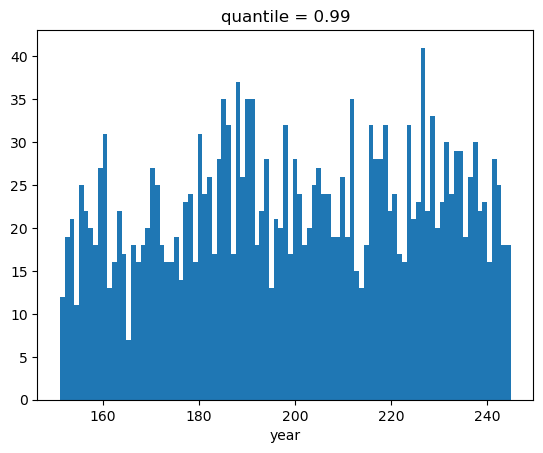

In [46]:
time_q.dt.year.plot.hist(bins=95)
time_q2.dt.year.plot.hist(bins=95)

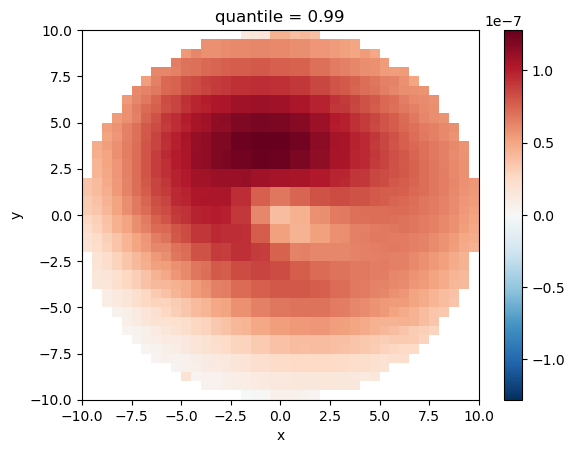

In [45]:
dic_masked[:,:,idx_q].mean(dim='snapshot').plot(y='y')

In [4]:
X = np.meshgrid(ds_massin.x.data,ds_massin.y.data)
mask = xr.DataArray(np.sqrt(X[0]**2 + X[1]**2) <= 10, dims=['x', 'y'])

test = ds_massin.snap_net_massin_anom
test = xr.where(abs(test)>1e10, np.nan, test)
test = xr.where(test==0, np.nan, test)

massin_masked = xr.where(mask, test, np.nan)

test = ds_massout.snap_net_massout_anom
test = xr.where(abs(test)>1e10, np.nan, test)
test = xr.where(test==0, np.nan, test)

massout_masked = xr.where(mask, test, np.nan)

ds_mass_masked = massin_masked.mean(dim="snapshot").to_dataset(name="massin")
ds_mass_masked.update({"massout": massout_masked.mean(dim="snapshot")})

<xarray.Dataset>
Dimensions:  (x: 40, y: 40)
Coordinates:
  * x        (x) float64 -9.75 -9.25 -8.75 -8.25 -7.75 ... 8.25 8.75 9.25 9.75
  * y        (y) float64 -9.75 -9.25 -8.75 -8.25 -7.75 ... 8.25 8.75 9.25 9.75
Data variables:
    massin   (x, y) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>
    massout  (x, y) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>

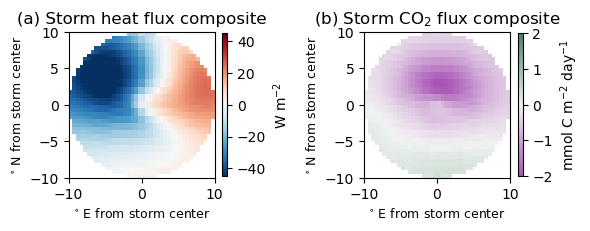

In [7]:
fig, axs = plt.subplots(figsize=(6,5.5), ncols=2, nrows=1)
axs=axs.flatten()

hfds_masked.mean(dim="snapshot").plot(ax=axs[0], y='y', cmap="RdBu_r",
                                     vmin=-45, vmax=45, extend="neither",
                                      cbar_kwargs = {'fraction': 0.03,
                                                    'aspect': 30,
                                                    'shrink': 0.7,
                                                    'label':'W m$^{-2}$'})


(1e3* 60**2 * 24 * dic_masked.mean(dim="snapshot")).plot(ax=axs[1], y='y', 
                                     cmap=sb.diverging_palette(300, 145, s=60, as_cmap=True),
                                     vmin=-2, vmax=2, extend="neither",
                                     cbar_kwargs = {'fraction': 0.03,
                                                    'aspect': 30,
                                                    'shrink': 0.7,
                                                    'label':'mmol C m$^{-2}$ day$^{-1}$'})


titles = ["(a) Storm heat flux composite", "(b) Storm CO$_2$ flux composite"]
for i in np.arange(2):
    axs[i].set_ylabel('$^{\circ}$ N from storm center', fontsize=9)
    axs[i].set_xlabel('$^{\circ}$ E from storm center', fontsize=9)
    axs[i].set_title(titles[i])
    axs[i].set_aspect(1)
    
plt.tight_layout()

plt.savefig("/work/Katherine.Turner/CM4_storms/analysis_figures/storm_comp_flux_anom_2panel.png",
           format="png",
           dpi=100,
           bbox_inches="tight")
plt.savefig("/home/Katherine.Turner/Figures/tempest-extremes/composite_fluxes/storm_comp_flux_anom_2panel.png",
           format="png",
           dpi=100,
           bbox_inches="tight")
plt.savefig("/home/Katherine.Turner/storm_comp_flux_anom_2panel.eps",
           format="eps")

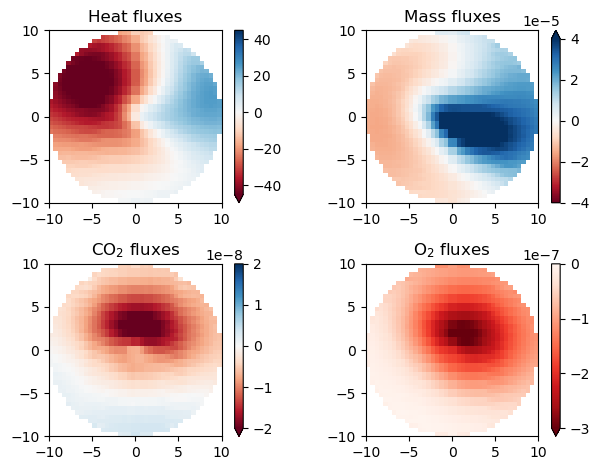

In [7]:
fig, axs = plt.subplots(ncols=2, nrows=2)
axs=axs.flatten()

hfds_masked.mean(dim="snapshot").plot(ax=axs[0], y='y', cmap="RdBu",
                                     vmin=-45, vmax=45)

(ds_mass_masked.massin + ds_mass_masked.massout).plot(ax= axs[1], y='y', cmap="RdBu", 
                                                     vmin=-4e-5, vmax=4e-5)

dic_masked.mean(dim="snapshot").plot(ax=axs[2], y='y', cmap="RdBu",
                                    vmin=-2e-8, vmax=2e-8)

o2_masked.mean(dim="snapshot").plot(ax=axs[3], y='y', cmap="Reds_r", vmin=-3e-7, vmax=0)


titles = ["Heat fluxes", "Mass fluxes", "CO$_2$ fluxes", "O$_2$ fluxes" ]
for i in np.arange(4):
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].set_title(titles[i])
    axs[i].set_aspect(1)
    
plt.tight_layout()

plt.savefig("/work/Katherine.Turner/CM4_storms/analysis_figures/storm_comp_flux_anom.png",
           format="png",
           dpi=100,
           bbox_inches="tight")